## NYC Taxi Trip Duration - Exploratory Data Analysis

### Objective of the EDA 

This notebook aims to conduct a thorough exploratory data analysis (EDA) on the NYC Taxi Trip Duration dataset with the following goals:

1. Understand each feature independently and explore their relationship with the target variable.
2. Focus on feature engineering by identifying new, meaningful features that could improve model performance.
3. Provide insights that will guide the modeling phase, including hypotheses that can be validated later during training and evaluation.
4. Build intuition about data quality and cleanliness, identifying which columns are noisy, irrelevant, or candidates for removal.

---

### Target Variable

The target variable is `trip_duration` (measured in seconds). However, due to the highly skewed nature of this variable, we will primarily work with its `log1p` transformation `log_trip_duration`. Applying `log1p` reduces the influence of extreme values and helps stabilize the variance, which can improve model performance. This transformation will be validated through visual and statistical analysis.

---
### EDA Structure

Below is an outline of the EDA sections to guide navigation and ensure coverage of key areas.

<details>
<summary><strong>Click to expand the EDA Sections</strong></summary>

- [Load and Inspect the Data](#load-and-inspect-the-data)  
  Load the dataset, check its shape, structure, and basic statistics.

- [1. Dataset Feature Descriptions](#1-columns-and-descriptions)  
  Explanation of each feature in the dataset.

- [2. Data Cleaning and Preprocessing](#2-data-cleaning-and-preprocessing)  
  Handle missing values, fix data types, and prepare for analysis.

- [3. Outlier Detection and Target Variable Transformation](#3-outlier-detection-and-target-variable-transformation)  
  Visualize and understand outliers and whether log1p is needed.

- [4. Categorical Feature Analysis](#4-categorical-feature-analysis)   
  Analyze categorical features and their effect on trip duration.

- [5. Geographical Feature Analysis](#5-Geographical-feature-analysis)  
  Examine how location-based features like pickup and dropoff coordinates affect trip behavior.

- [6. Temporal Feature Analysis](#6-temporal-feature-analysis)  
  Analyze how trip behavior is influenced by time-related features such as pickup time and trip duration.

- [7. Relationships Between Features](#7-relationships-between-features)  
  Examine how features interact or correlate with one another.

- [8. Feature Engineering](#8-feature-engineering)  
  Create, evaluate, and justify new features that may improve the model.

- [9. Summary and Next Steps](#9-summary-and-next-steps)  
  Wrap up findings, hypotheses, and prepare for modeling.

- [Acknowledgments](#acknowledgments)

</details>


### Load and Inspect The Data

In [379]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [380]:
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_rows = 500

import warnings

# ignore FutureWarnings and UserWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [381]:
df = pd.read_csv("../data/split/train.csv")
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [382]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


In [383]:
df.select_dtypes("object").describe().T

,count,unique,top,freq
id,1000000,1000000,id2793718,1
pickup_datetime,1000000,962731,2016-04-05 18:55:21,5
store_and_fwd_flag,1000000,2,N,994443


In [384]:
df.shape

(1000000, 10)

[(back to top)](#eda-structure)

### 1. Columns and Descriptions

In [385]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

- **id**  
  A unique identifier assigned to each trip.

- **vendor_id**  
  Indicates the taxi provider that handled the trip. Each provider is represented by a code (e.g., 1 or 2).

- **pickup_datetime**  
  The exact date and time when the trip began — when the meter was turned on.

- **passenger_count**  
  The number of passengers in the vehicle, as entered by the driver.

- **pickup_longitude**  
  The longitude coordinate where the trip started.

- **pickup_latitude**  
  The latitude coordinate where the trip started.

- **dropoff_longitude**  
  The longitude where the trip ended.

- **dropoff_latitude**  
  The latitude where the trip ended.

- **store_and_fwd_flag**  
  A flag that indicates whether the trip data was **stored temporarily in the vehicle’s memory** before being sent to the server.  
  - `"Y"` means **store and forward** (no immediate connection, sent later).  
  - `"N"` means **real-time transmission** (sent directly when trip ended).  

- **trip_duration**  
  The duration of the trip in **seconds**.



[(back to top)](#eda-structure)

### 2. Data Cleaning and Preprocessing

#### 2.1 Handling Missing Values

In [386]:
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values in the dataset, so no further action is required in this regard.

#### 2.2 Correcting Data Types

In [387]:
def describe_column(df, column_name):
    print(f"Column: {column_name}")
    print(f"Data type: {df[column_name].dtype}")
    print(f"Number of unique values: {df[column_name].nunique()}")
    print("\nHead (first 5 values):")
    print(df[column_name].head())
    print("\nTail (last 5 values):")
    print(df[column_name].tail())
    print("-----------------------\n")

for col in df.columns:
    describe_column(df, col)

Column: id
Data type: object
Number of unique values: 1000000

Head (first 5 values):
0    id2793718
1    id3485529
2    id1816614
3    id1050851
4    id0140657
Name: id, dtype: object

Tail (last 5 values):
999995    id2875371
999996    id1038420
999997    id3238884
999998    id3652642
999999    id0887693
Name: id, dtype: object
-----------------------

Column: vendor_id
Data type: int64
Number of unique values: 2

Head (first 5 values):
0    2
1    2
2    2
3    2
4    1
Name: vendor_id, dtype: int64

Tail (last 5 values):
999995    2
999996    2
999997    2
999998    2
999999    2
Name: vendor_id, dtype: int64
-----------------------

Column: pickup_datetime
Data type: object
Number of unique values: 962731

Head (first 5 values):
0    2016-06-08 07:36:19
1    2016-04-03 12:58:11
2    2016-06-05 02:49:13
3    2016-05-05 17:18:27
4    2016-05-12 17:43:38
Name: pickup_datetime, dtype: object

Tail (last 5 values):
999995    2016-03-25 15:48:58
999996    2016-05-04 19:36:44
999997    2

- We can start by dropping the `id` column since it won't be useful for the analysis.
- The `vendor_id` column is stored as an integer, but since it contains only two unique values, we will convert it to a categorical type. 
- The same applies to `passenger_count` & `store_and_fwd_flag` columns, which will also be converted to a categorical variable. 
- Finally, the `pickup_datetime` column will be converted to a proper datetime type to enable more effective time-based analysis.

In [388]:
df = df.drop('id', axis=1)  # dropping id column

# Fixing Data Types
df['vendor_id'] = df['vendor_id'].astype('category')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')
df['passenger_count'] = df['passenger_count'].astype('category')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

#### 2.3 Handling Duplicate Values

In [389]:
df.duplicated().sum()

np.int64(4)

We have 4 duplicate rows that we can remove.

In [390]:
df = df.drop_duplicates()

#### Final Result

In [391]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
pickup_datetime,999996,2016-04-01 08:53:24.570977536,2016-01-01 00:00:53,2016-02-17 15:26:19.750000128,2016-04-01 15:01:43.500000,2016-05-15 02:35:46.500000,2016-06-30 23:59:37,NaN
pickup_longitude,999996.0,-73.973475,-121.933342,-73.991852,-73.981728,-73.967346,-61.335529,0.065404
pickup_latitude,999996.0,40.750947,34.359695,40.737373,40.754131,40.768379,51.881084,0.033745
dropoff_longitude,999996.0,-73.973421,-121.933304,-73.991341,-73.979767,-73.963036,-61.335529,0.065432
dropoff_latitude,999996.0,40.751829,34.359695,40.735928,40.754551,40.769833,43.921028,0.035782
trip_duration,999996.0,954.883049,1.0,397.0,662.0,1074.0,2227612.0,3882.075043


In [392]:
df.select_dtypes("category").describe().T

,count,unique,top,freq
vendor_id,999996,2,2,534789
passenger_count,999996,8,1,708628
store_and_fwd_flag,999996,2,N,994439


**Summary:**
The dataset now contains 9 features, which can be grouped into the following categories:

* **Numerical (Target):**

  * `trip_duration`

* **Categorical:**

  * `vendor_id`, `store_and_fwd_flag`, `passenger_count`

* **Geographical Coordinates:**

  * `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`

* **Datetime:**

  * `pickup_datetime`


We will organize the exploratory analysis into three sections based on these groups, starting with the **categorical features**.

[(back to top)](#eda-structure)

### 3. Outlier Detection and Target Variable Transformation

#### 3.1 Handling Categorical Variables

In [393]:
def describe_categorical_column(df, name):
    col = df[name]
    print(f"Column name: {col.name}")
    print(f"Unique: {col.nunique()}")
    print(col.value_counts())
    print("----------------------\n")

for name in df.select_dtypes("category"):
    describe_categorical_column(df, name)

Column name: vendor_id
Unique: 2
vendor_id
2    534789
1    465207
Name: count, dtype: int64
----------------------

Column name: passenger_count
Unique: 8
passenger_count
1    708628
2    143905
5     53635
3     41011
6     33287
4     19490
0        38
7         2
Name: count, dtype: int64
----------------------

Column name: store_and_fwd_flag
Unique: 2
store_and_fwd_flag
N    994439
Y      5557
Name: count, dtype: int64
----------------------



As shown above, both `store_and_fwd_flag` and `vendor_id` have balanced distributions and do not indicate any outliers. However, when examining `passenger_count`, we notice some unusual values such as 0 and 7. A quick check reveals that NYC taxis typically accommodate up to 5 passengers, with the possibility of one additional child, bringing the maximum realistic count to 6. Therefore, entries with a passenger count of 7 are likely data entry errors and can be safely removed from the dataset.


In [394]:
# dropping outliers in passenger_count:
df = df[(df['passenger_count'] != 7) & (df['passenger_count'] != 0)]

In [395]:
df.passenger_count.value_counts()

passenger_count
1    708628
2    143905
5     53635
3     41011
6     33287
4     19490
0         0
7         0
Name: count, dtype: int64

#### 3.2 Handling Geographical Coordinates

In [396]:
def describe_geo_column(df, column_name):
    print(f"Column: {column_name}")
    print("\nHead (first 5 values):")
    print(df[column_name].sort_values().head())
    print("\nTail (last 5 values):")
    print(df[column_name].sort_values().tail())
    print("-----------------------\n")

geo_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

for col in geo_features:
    describe_geo_column(df, col)

Column: pickup_longitude

Head (first 5 values):
432909   -121.933342
635872    -79.487900
215911    -78.547401
67878     -77.896019
401259    -77.440750
Name: pickup_longitude, dtype: float64

Tail (last 5 values):
775523   -70.851616
957257   -66.972160
173578   -65.897385
904853   -65.848389
486737   -61.335529
Name: pickup_longitude, dtype: float64
-----------------------

Column: pickup_latitude

Head (first 5 values):
904853    34.359695
491566    35.081532
67443     35.310307
401259    36.029301
432909    37.389381
Name: pickup_latitude, dtype: float64

Tail (last 5 values):
315596    43.139652
999956    43.486885
862890    43.911762
957257    44.371944
881917    51.881084
Name: pickup_latitude, dtype: float64
-----------------------

Column: dropoff_longitude

Head (first 5 values):
432909   -121.933304
31634     -79.817978
215911    -79.786133
659882    -79.553535
845202    -79.518616
Name: dropoff_longitude, dtype: float64

Tail (last 5 values):
409677   -70.346077
957257   -

We observe that latitude values range from 34 to 51, and longitude values range from -121 to -60.
However, since our focus is on NYC, a quick check on Google Maps shows that valid coordinates for the city should fall approximately between **40 and 43 latitude**, and **-75 and -73 longitude**, with a small buffer around these ranges.
This clearly indicates the presence of outliers, which we can safely remove.

In [397]:
df = df[(df["dropoff_latitude"] < 43) & (df["dropoff_latitude"] > 40)]
df = df[(df["pickup_latitude"] < 43) & (df["pickup_latitude"] > 40)]
df = df[(df["pickup_longitude"] < -73) & (df["pickup_longitude"] > -75)]
df = df[(df["dropoff_longitude"] < -73) & (df["dropoff_longitude"] > -75)]

#### 3.3 Handling Datetime Features

In [398]:
print(df["pickup_datetime"].sort_values().head())
print(df["pickup_datetime"].sort_values().tail())

269293   2016-01-01 00:00:53
196847   2016-01-01 00:01:20
161483   2016-01-01 00:01:47
755913   2016-01-01 00:02:06
363445   2016-01-01 00:02:45
Name: pickup_datetime, dtype: datetime64[ns]
892037   2016-06-30 23:58:47
498992   2016-06-30 23:58:52
653969   2016-06-30 23:59:09
67771    2016-06-30 23:59:10
497894   2016-06-30 23:59:37
Name: pickup_datetime, dtype: datetime64[ns]


All datetime entries fall between January and June 2016, with no noticeable anomalies requiring removal.

#### 3.4 Handling Target Variable

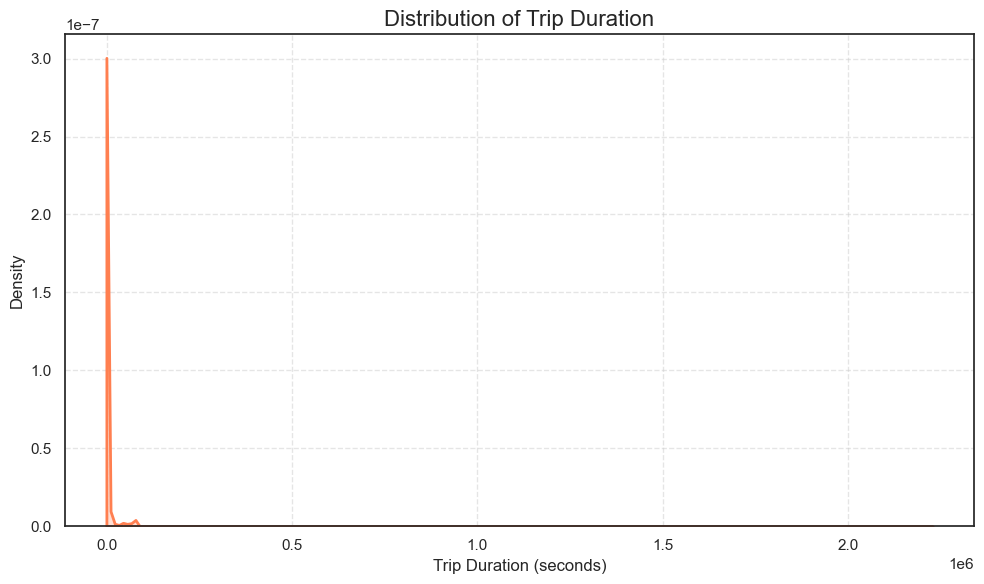

In [399]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df["trip_duration"], fill=True, color="coral", linewidth=2)

plt.title("Distribution of Trip Duration", fontsize=16)
plt.xlabel("Trip Duration (seconds)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [400]:
print(df["trip_duration"].mean())  # mean
print(df["trip_duration"].median())  # median
print(df["trip_duration"].skew())  # skewness

954.8541171834919
662.0
202.56777109641183


##### Observations:

Based on the information above, we can draw several key insights:

1. **The mean is significantly higher than the median**, indicating strong right skewness. This is expected, as the mean is more sensitive to extreme values (outliers), while the median is more robust.
2. **The skewness value further supports this**, confirming that the distribution is indeed heavily skewed to the right.
3. **The KDE plot also reflects this skew**, showing a long tail and compressed variation in the main range, with a sharp peak and a long stretch to the right.

##### Handling the Skewness:

To address this issue, we’ll apply two key techniques:

1. **Outlier Removal** using the IQR (Interquartile Range) method to eliminate extreme values.
2. **Log Transformation** using `log1p` to compress the scale and make the distribution more interpretable.

##### Why We Use `log1p(trip_duration)`:

Due to the highly skewed nature of the original `trip_duration`, we will model the **log-transformed** values instead. This transformation improves the distribution’s shape, makes statistical analysis and visualizations more meaningful, and increases the likelihood of better model performance in later stages.

**Important:** After making predictions in the log-transformed space, we can simply reverse the transformation using `np.expm1()` to recover the actual trip duration.
This ensures no loss of interpretability or real-world meaning — it's a safe and widely-used technique in data science.

In [401]:
# Handling outliers
q1 = df["trip_duration"].quantile(0.25)
q3 = df["trip_duration"].quantile(0.75)
iqr = q3 - q1

# will use 10 as multiplier to avoid dropping much data
upper_whisker = q3 + 1.5*iqr
lower_whisker = q1 - 1.5*iqr

df = df[df["trip_duration"].between(lower_whisker, upper_whisker)]

# Using log1p
df["log_trip_duration"] = np.log1p(df["trip_duration"])
df.drop("trip_duration", axis=1, inplace=True)

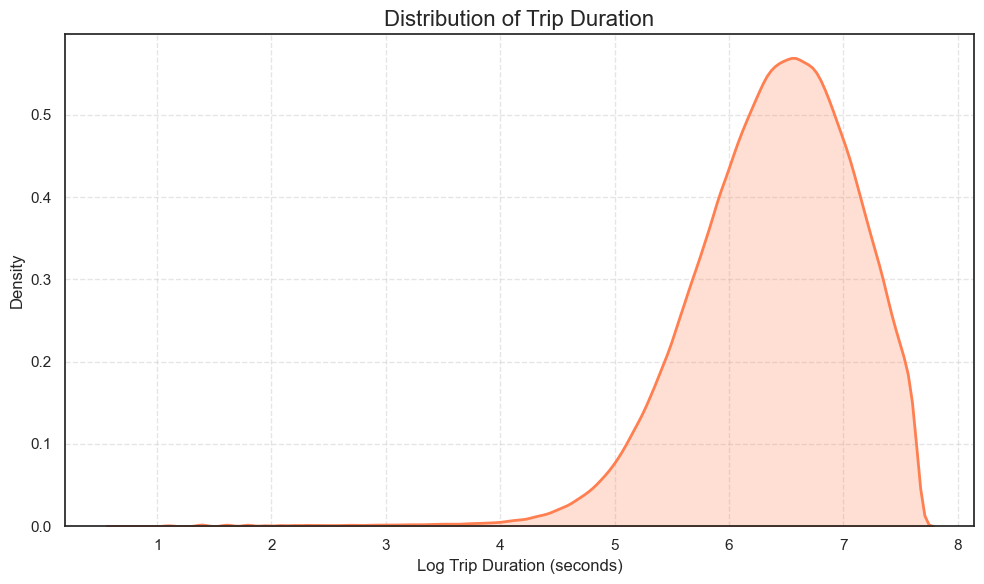

In [402]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df["log_trip_duration"], fill=True, color="coral", linewidth=2)

plt.title("Distribution of Trip Duration", fontsize=16)
plt.xlabel("Log Trip Duration (seconds)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [403]:
print(df["log_trip_duration"].mean())  # mean
print(df["log_trip_duration"].median())  # median
print(df["log_trip_duration"].skew())  # skewness

6.383244013283965
6.448889394146858
-1.009125185656205


We can clearly observe a significant improvement in the distribution after the transformation. The plot is now much clearer and easier to interpret, making it more suitable for analysis. Statistically, the mean is now very close to the median, indicating that the extreme outliers have been effectively removed. Although the distribution is now slightly left-skewed, it is still a major improvement compared to the original, heavily right-skewed version.

[(back to top)](#eda-structure)

### 4. Categorical Feature Analysis

In [404]:
df.select_dtypes("category").columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag'], dtype='object')

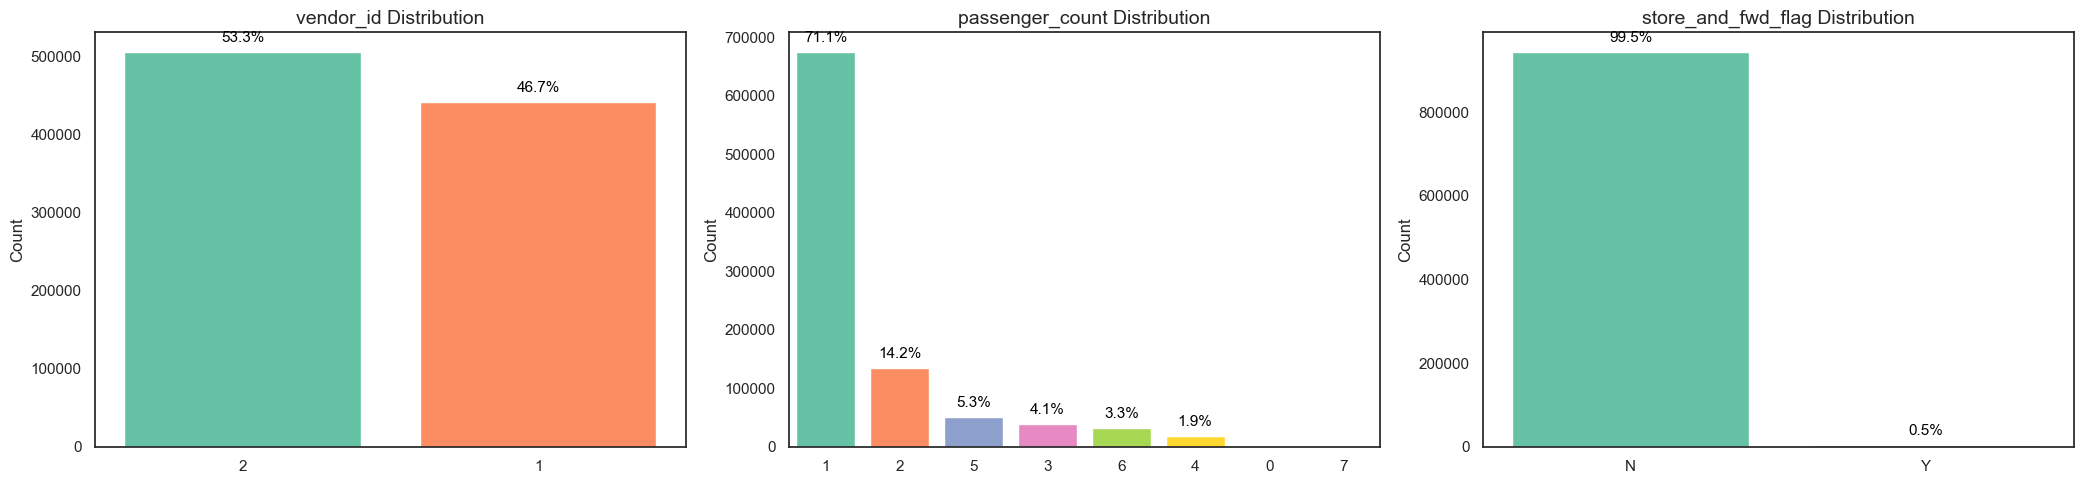

In [405]:
cat_cols = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']
n = len(cat_cols)

fig, axes = plt.subplots(1, n, figsize=(7 * n, 5))
sns.set_theme(style="whitegrid")

for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    counts = df[col].value_counts()
    total = counts.sum()
    order = counts.index

    # Draw basic countplot (no palette to avoid FutureWarning)
    plot = sns.countplot(data=df, x=col, ax=ax, order=order)

    # Manually color bars
    colors = sns.color_palette('Set2', len(order))
    for patch, color in zip(ax.patches, colors):
        patch.set_facecolor(color)

    # Style
    ax.set_title(f'{col} Distribution', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(order, ha='center', fontsize=11)

    # Add percentages
    for p in ax.patches:
        height = p.get_height()
        percent = f'{(height / total) * 100:.1f}%'
        ax.annotate(percent, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()


**Observations:**

1. **Vendor ID Distribution**
   We observe that Vendor ID 2 has a slightly higher number of trips, accounting for about 6.8% more than Vendor ID 1. Assuming both vendors operate for similar durations and under comparable conditions, this could suggest that Vendor 2 tends to have shorter trip durations. However, further analysis would be needed to confirm this assumption.

2. **Passenger Count Distribution**
   The bar chart clearly shows that most trips are taken by a single passenger. As the passenger count increases, the number of trips significantly decreases. This trend might reflect modern urban lifestyles, where people often travel alone rather than in groups.

3. **Store and Forward Flag**
   The majority of trips are labeled with the `"N"` flag, indicating real-time data transmission (i.e., trip data sent immediately after completion). Only a small fraction (about 0.6%) of trips are marked with the `"Y"` flag, which means the trip data was stored and sent later due to a lack of network connectivity at the time. This could occur if the taxi traveled through areas with poor signal coverage or if there was a temporary issue with the communication device.

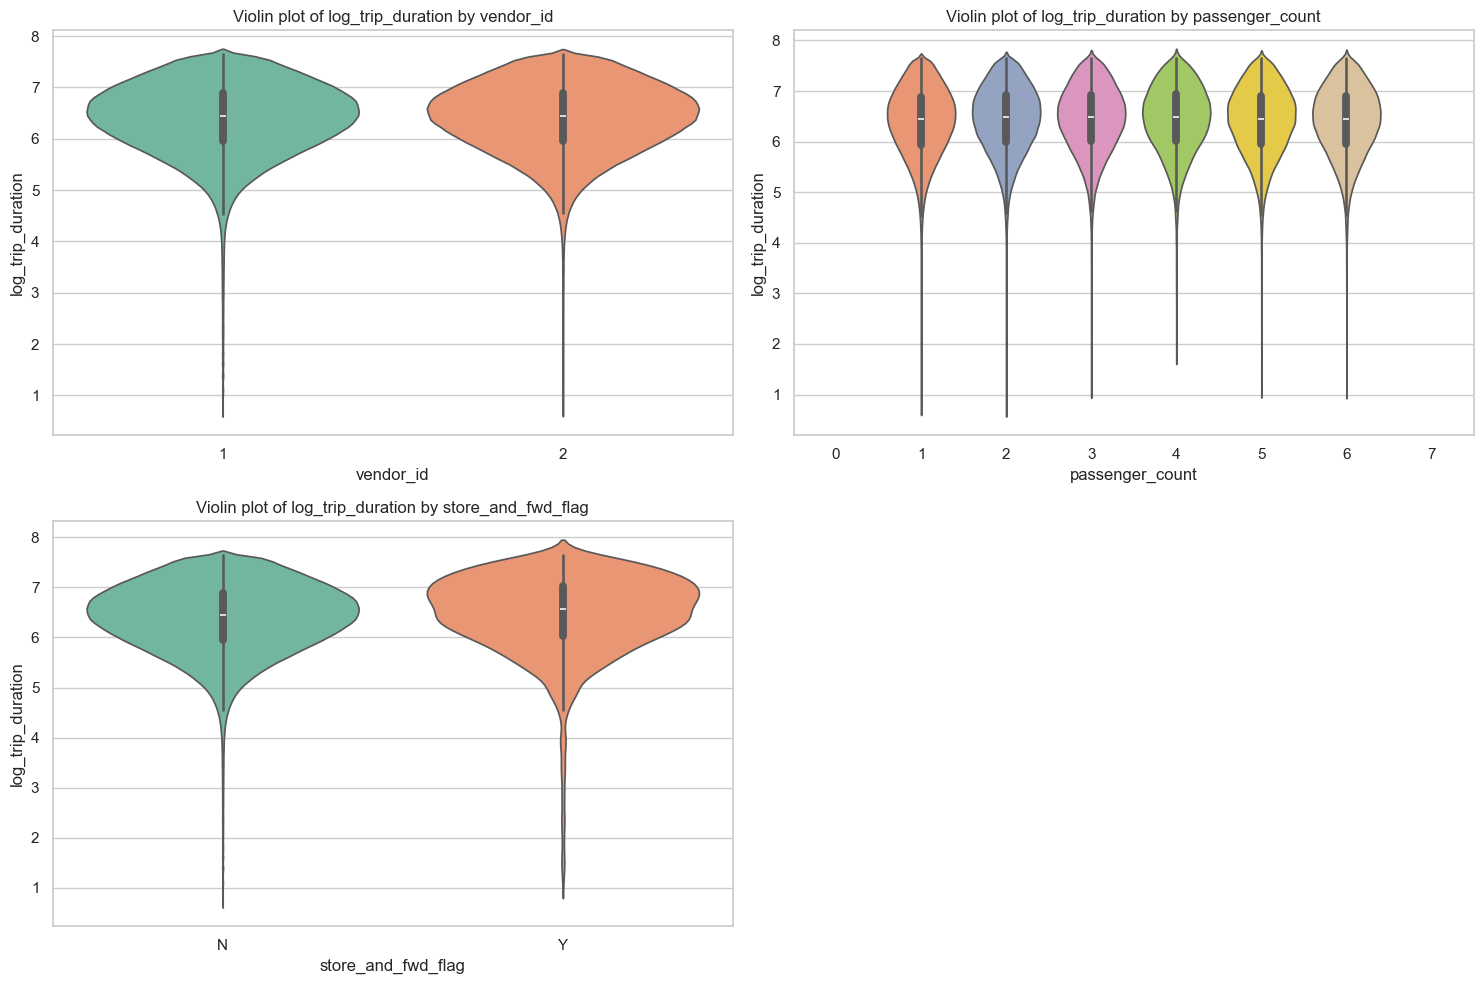

In [406]:
cat_cols = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']
target = 'log_trip_duration'

plt.figure(figsize=(15, 10))
palette = sns.color_palette("Set2")

for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    ax = sns.violinplot(x=col, y=target, data=df, palette=palette)
    plt.title(f'Violin plot of {target} by {col}')
    plt.xticks(ha='center')

plt.tight_layout()
plt.show()


**Observations: (Feature - Target Relationship)**

1. **Vendor ID:**
   The violin plot indicates that both vendors have **very similar trip duration distributions**, contradicting our earlier assumption that *Vendor 2* had shorter trips (which would explain its higher trip count). Given that the durations are nearly the same, it’s more likely that *Vendor 2 simply operates more frequently or for longer hours* than *Vendor 1*.
   Since `vendor_id` is just a categorical label, using one-hot encoding is recommended to avoid introducing unintended ordinal relationships (e.g., `2 > 1`). Alternatively, the feature could be dropped if it adds little value.

2. **Passenger Count:**
   The trip duration distribution appears consistent across all passenger counts. This suggests that the number of passengers **does not significantly influence** the length of the trip. As with `vendor_id`, one-hot encoding is suitable here to prevent misleading the model into interpreting higher passenger counts as meaningfully larger values.

3. **Store and Forward Flag:**
   Trips with the `"Y"` flag (i.e., not transmitted in real-time) tend to have **slightly longer durations** and greater density in the higher range, compared to those with `"N"` (real-time). This supports our earlier hypothesis: trips with `"Y"` were likely longer or took place in areas with poor connectivity. Since this feature carries subtle but relevant information, **target encoding** may be useful to reflect the mean difference in trip durations.

In [407]:
# Comparing means and skewness of store_and_fwd_flag flags N & Y
Y_df = df[df['store_and_fwd_flag'] == 'Y']
N_df = df[df['store_and_fwd_flag'] == 'N']

print(f"Y flag mean log trip duration: {Y_df['log_trip_duration'].mean()}")
print(f"N flag mean log trip duration: {N_df['log_trip_duration'].mean()}\n")

print(f"Y flag log trip duration skewness: {Y_df['log_trip_duration'].skew()}")
print(f"N flag log trip duration skewness: {N_df['log_trip_duration'].skew()}")

Y flag mean log trip duration: 6.44742584556156
N flag mean log trip duration: 6.382911786522571

Y flag log trip duration skewness: -1.8846907605454968
N flag log trip duration skewness: -1.002010809129544


We observe two key points:

* The mean log trip duration for the `Y` flag is slightly higher than that for the `N` flag.
* The distribution for `Y` is more left-skewed compared to `N`.

Taken together, these observations suggest something interesting: despite having more lower values (due to stronger left skew), the `Y` group still has a higher mean. For this to be true, the `Y` group must also contain **more high-duration trips** than the `N` group to offset the impact of those low values.

To confirm this further, we expect the **median** log trip duration for the `Y` group to be **noticeably higher** than that of the `N` group—likely with a greater difference than what we saw in the means.

In [408]:
print(f"Y flag median log trip duration: {Y_df['log_trip_duration'].median()}")
print(f"N flag median log trip duration: {N_df['log_trip_duration'].median()}\n")


Y flag median log trip duration: 6.566672429803241
N flag median log trip duration: 6.448889394146858



We observe that the median log trip duration for the `Y` flag is higher, with a difference of approximately 2.1 compared to the `N` flag, while the difference in means is only around 0.18. This supports our earlier hypothesis and confirms that trips with the `Y` flag tend to have longer durations.

[(back to top)](#eda-structure)

### 5. Geographical Feature Analysis

In [409]:
geo_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

Since these features represent coordinates, plotting them as a scatter plot provides a general map view of the area. To make the visualization more insightful, I will color pickups and dropoffs with different colors, where the color intensity increases as the target variable (trip duration) increases for both.

This approach offers several insights:

1. Pickups with lighter colors tend to correspond to dropoffs with lighter colors, and similarly for denser, darker colors.
2. We can easily identify areas with the highest concentration of pickups and those with the most dropoffs.

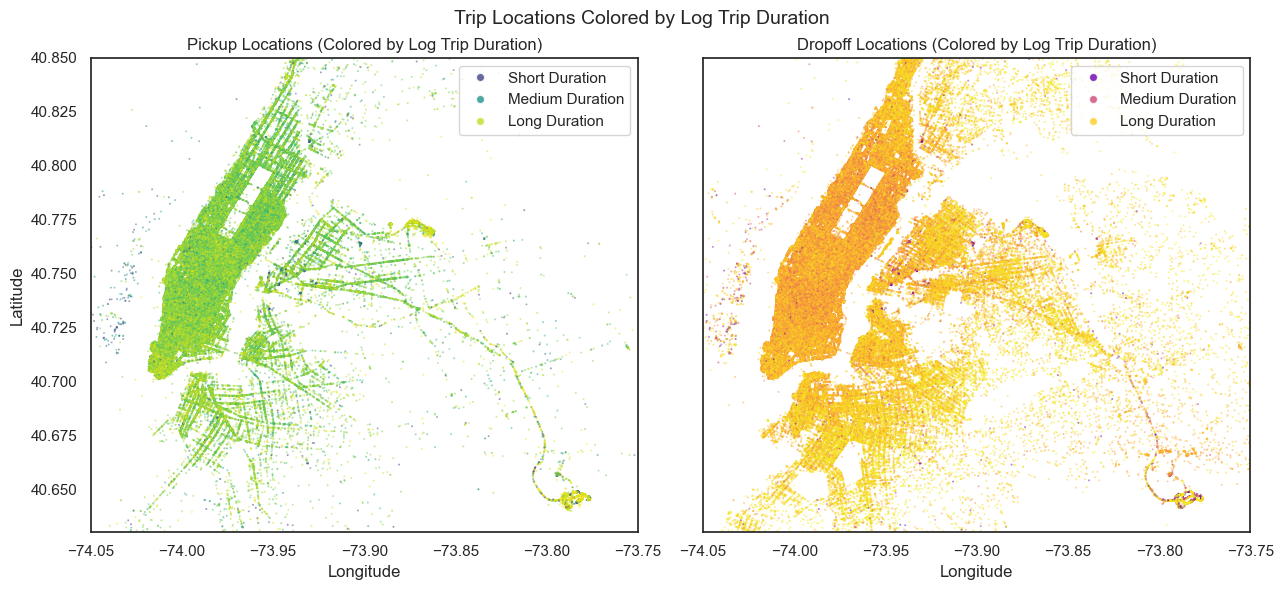

In [410]:
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Normalize color range using log_trip_duration
norm = Normalize(vmin=df['log_trip_duration'].min(), vmax=df['log_trip_duration'].max())

# Generate color mappings
pickup_colors = plt.cm.viridis(norm(df['log_trip_duration']))
dropoff_colors = plt.cm.plasma(norm(df['log_trip_duration']))

# Setup the side-by-side plots
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

# ----- Pickup subplot -----
axes[0].scatter(
    df['pickup_longitude'],
    df['pickup_latitude'],
    c=pickup_colors,
    s=2,
    alpha=0.5,
    edgecolors='none'
)
axes[0].set_title('Pickup Locations (Colored by Log Trip Duration)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Custom legend for pickup (viridis)
pickup_legend = [
    Line2D([0], [0], marker='o', color='w', label='Short Duration',
           markerfacecolor=plt.cm.viridis(0.2), markersize=6, alpha=0.8),
    Line2D([0], [0], marker='o', color='w', label='Medium Duration',
           markerfacecolor=plt.cm.viridis(0.5), markersize=6, alpha=0.8),
    Line2D([0], [0], marker='o', color='w', label='Long Duration',
           markerfacecolor=plt.cm.viridis(0.9), markersize=6, alpha=0.8),
]
axes[0].legend(handles=pickup_legend, loc='upper right')

# ----- Dropoff subplot -----
axes[1].scatter(
    df['dropoff_longitude'],
    df['dropoff_latitude'],
    c=dropoff_colors,
    s=2,
    alpha=0.5,
    edgecolors='none'
)
axes[1].set_title('Dropoff Locations (Colored by Log Trip Duration)')
axes[1].set_xlabel('Longitude')

# Custom legend for dropoff (plasma)
dropoff_legend = [
    Line2D([0], [0], marker='o', color='w', label='Short Duration',
           markerfacecolor=plt.cm.plasma(0.2), markersize=6, alpha=0.8),
    Line2D([0], [0], marker='o', color='w', label='Medium Duration',
           markerfacecolor=plt.cm.plasma(0.5), markersize=6, alpha=0.8),
    Line2D([0], [0], marker='o', color='w', label='Long Duration',
           markerfacecolor=plt.cm.plasma(0.9), markersize=6, alpha=0.8),
]
axes[1].legend(handles=dropoff_legend, loc='upper right')

# Set NYC area zoom
for ax in axes:
    ax.set_xlim(-74.05, -73.75)
    ax.set_ylim(40.63, 40.85)

# Overall title
plt.suptitle('Trip Locations Colored by Log Trip Duration', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



#### **Understanding the Graph:**
The scatter plots display the pickup and dropoff locations of taxi trips across New York City, forming the recognizable shape of the city on the map. Colors represent log-transformed trip durations, where lighter colors (yellows and greens) correspond to longer trips, and darker colors (deep blues and purples) represent shorter trips.

Logically, pickups with longer trip durations tend to correspond spatially with dropoffs of similarly long durations—meaning that areas shown in light green for pickups typically align with light yellow areas for dropoffs, while darker pickup points correspond to darker dropoff regions.

#### **Key Locations Referenced (via Google Maps)**:
- [New York City (NYC) Map](https://maps.app.goo.gl/F7qZ9hWxQt1TbNx6A)
- [John F. Kennedy (JFK) International Airport](https://maps.app.goo.gl/uzSfZBkRtatqqVaU6)
- [LaGuardia (LG) Airport](https://maps.app.goo.gl/fuc9EWMHKCYD4nEZ6)

#### **Observations:**

1. **Medium Trip Durations Concentrated Around Manhattan:**

   * The **green tones** (representing medium durations) are densest around **Manhattan**, especially near **Times Square** and Midtown.
   * This suggests that **many trips begin or end here**, with durations that are neither too short nor too long—likely due to **moderate traffic** and **central location**.
   * Shorter trips (dark colors) appear scattered throughout, especially on the city edges, while the longest trips (lightest colors) are more sparse but significant near key outer areas.

2. **Long Trip Durations Near JFK and LaGuardia Airports:**

   * Light-colored pickup points indicating longer trip durations cluster around both **JFK** (in the southeastern corner) and **LaGuardia Airport**, which is closer to downtown.
   * Based on the graph, we see that lighter colors in pickup locations correspond with lighter colors in dropoff locations, since both represent longer trip durations.
   * This shows that trips starting near airports tend to connect with destinations across the city, resulting in longer overall trips.
   * Overall, trips starting from or ending at airports generally have longer durations due to their distance from the city center and traffic conditions.


3. **Pickup vs Dropoff Patterns:**

   * **Pickups** are more tightly clustered around Manhattan, showing it's a **major starting point** for rides.
   * **Dropoffs** are more spread out, particularly in **residential areas** and **airport zones**, indicating passengers are heading out from downtown to various destinations.

4. **Transmission Flag "Y" Association:**

   * As JFK is located far from the city center, it’s plausible that **poor connectivity** there contributes to more trips being marked with `store_and_fwd_flag = "Y"`.
   * In our earlier [categorical analysis](#4-categorical-feature-analysis), we found that "Y" trips tend to have **longer durations**.
   * Next, I’ll visualize those "Y" flag trips separately to see if they **cluster around JFK or other outlying areas**, which may confirm the relationship.

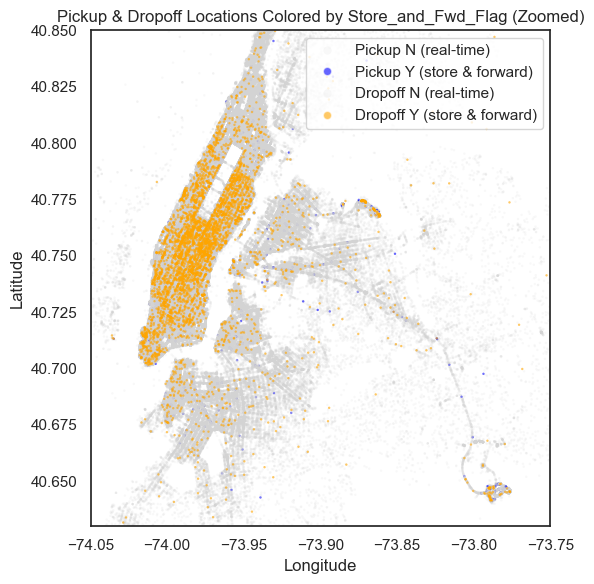

In [411]:
from matplotlib.lines import Line2D

# Define clear, distinct colors
colors_pickup = {
    'N': 'lightgray',    # subtle for 'N'
    'Y': 'blue'          # bright blue for pickup 'Y'
}

colors_dropoff = {
    'N': 'lightgray',    # subtle for 'N'
    'Y': 'orange'        # bright orange for dropoff 'Y'
}

plt.figure(figsize=(6, 6))
sns.set_theme(style="white")

# Plot pickups
for flag in ['N', 'Y']:
    subset = df[df['store_and_fwd_flag'] == flag]
    plt.scatter(
        subset['pickup_longitude'],
        subset['pickup_latitude'],
        c=colors_pickup[flag],
        s=3,
        alpha=0.6 if flag == 'Y' else 0.15,
        label=f'Pickup {flag}',
        edgecolors='none'
    )

# Plot dropoffs
for flag in ['N', 'Y']:
    subset = df[df['store_and_fwd_flag'] == flag]
    plt.scatter(
        subset['dropoff_longitude'],
        subset['dropoff_latitude'],
        c=colors_dropoff[flag],
        s=3,
        alpha=0.6 if flag == 'Y' else 0.15,
        label=f'Dropoff {flag}',
        edgecolors='none'
    )

# Zoom to NYC area
plt.xlim(-74.05, -73.75)
plt.ylim(40.63, 40.85)

# Labels and title
plt.title('Pickup & Dropoff Locations Colored by Store_and_Fwd_Flag (Zoomed)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Custom legend with new colors
custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Pickup N (real-time)', 
           markerfacecolor='lightgray', markersize=6, alpha=0.15),
    Line2D([0], [0], marker='o', color='w', label='Pickup Y (store & forward)', 
           markerfacecolor='blue', markersize=6, alpha=0.6),
    Line2D([0], [0], marker='o', color='w', label='Dropoff N (real-time)', 
           markerfacecolor='lightgray', markersize=6, alpha=0.15),
    Line2D([0], [0], marker='o', color='w', label='Dropoff Y (store & forward)', 
           markerfacecolor='orange', markersize=6, alpha=0.6),
]
plt.legend(handles=custom_legend, loc='upper right')

plt.tight_layout()
plt.show()


This plot displays all points with the `"N"` flag in light gray, while points flagged as `"Y"` are shown in yellow and blue—where **blue represents pickup locations** and **yellow represents dropoff locations**.

We observe that many pickups with the `"Y"` connectivity issue occur far from the city center, particularly around the airport. The concentration of blue points at the airport indicates that numerous trips starting there are marked with the `"Y"` flag. Meanwhile, the yellow points clustered in Manhattan show that many of these trips end downtown.

This pattern suggests that trips originating from the airport and ending in Manhattan are long-distance, often passing through less connected areas outside the city, which likely causes the `"Y"` store-and-forward flag to be set.

Additionally, the presence of yellow points at the airport indicates many dropoffs there also experience connectivity issues, further supporting the idea that trips flagged with `"Y"` are typically longer trips involving peripheral locations like the airport.

[(back to top)](#eda-structure)

### 6. Temporal Feature Analysis 

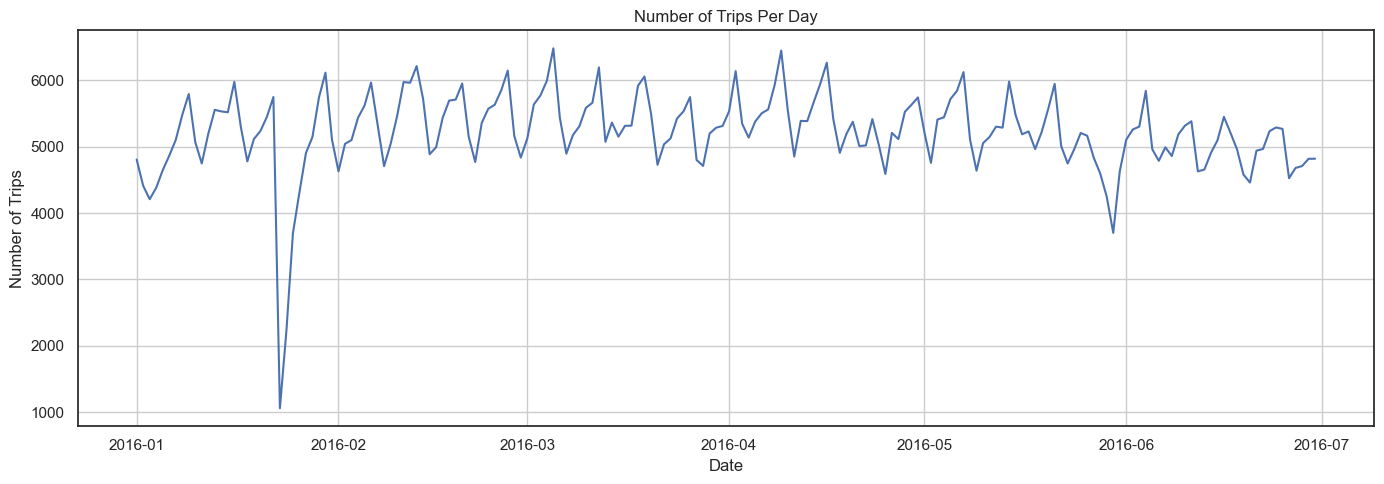

In [412]:
# Set datetime as index (temporarily)
df_day = df.set_index('pickup_datetime')

# Resample by day and count trips
daily_counts = df_day.resample('D').size()  # 'D' = daily frequency

# Plotting
plt.figure(figsize=(14, 5))
sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker='', linewidth=1.5)

plt.title('Number of Trips Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.tight_layout()
plt.show()

We can begin by examining the overall time series plot of daily trip counts. Most days appear to follow a consistent distribution; however, there's a noticeable drop in the number of trips on one of the last few days of January. This sharp decline stands out, prompting us to investigate what might have caused it.

In [413]:
# Sort and take the lowest 5 dates
daily_counts.sort_values().head()

pickup_datetime
2016-01-23    1063
2016-01-24    2228
2016-01-25    3695
2016-05-30    3701
2016-01-03    4208
dtype: int64

In [414]:
print(daily_counts['2016-01-22'])
print(daily_counts['2016-01-23'])
print(daily_counts['2016-01-24'])
print(daily_counts['2016-01-25'])
print(daily_counts['2016-01-26'])

5744
1063
2228
3695
4310


Between January 22 and January 23, there is a sharp decline in taxi trip counts, with a drop of over 4,000 trips that continues until January 24, after which the numbers begin to return to normal. While this sudden drop might seem unusual at first, a quick search reveals that from January 22 to 24, one of the worst blizzards in recent history occurred in NYC — described as a deadly storm. Given the extreme and rare nature of this event, with record-breaking snowfall, these dates can be considered outliers in terms of trip activity. We’ll keep this anomaly in mind as we analyze the upcoming plots.

For more details, see the [January 2016 United States blizzard Wikipedia page](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard).

One question that arises is whether the blizzard might be linked to the occurrences of the "Y" flags in the `store_and_fwd_flag` feature—where "Y" means **stored and sent later** due to no immediate connection. This could be caused by the blizzard’s impact on network connectivity. If so, these flagged trips might be considered outliers since such severe weather is rare. To check, I will count the occurrences of both flags during the anomaly period.

In [415]:
df_anomaly = df[('2016-01-25' >= df["pickup_datetime"]) & (df["pickup_datetime"] >= '2016-01-22')]
df_anomaly["store_and_fwd_flag"].value_counts()

store_and_fwd_flag
N    8985
Y      50
Name: count, dtype: int64

The counts indicate that the blizzard does not have a direct impact on the connection. However, ***we may still consider dropping these rows later*** since the blizzard likely made it difficult for taxis to navigate, resulting in longer trip durations than usual, which could skew the overall data distribution. Now, let’s move on to the next plot.

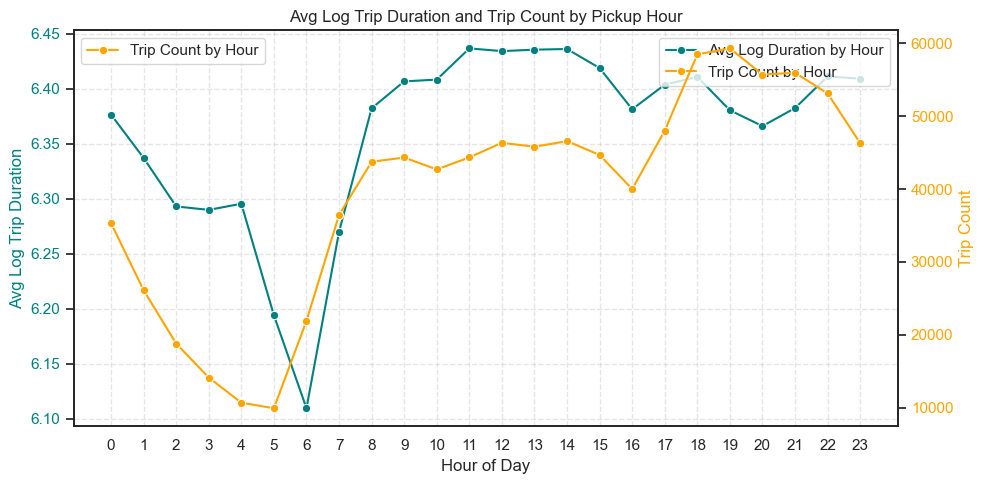

In [416]:
# Temporary hour column
hours = df['pickup_datetime'].dt.hour
log_durations = df['log_trip_duration']

# Create temporary DataFrame
temp_df = pd.DataFrame({'hour': hours, 'log_trip_duration': log_durations})

# Grouped values
avg_log_duration_by_hour = temp_df.groupby('hour')['log_trip_duration'].mean()
trip_count_by_hour = temp_df.groupby('hour').size()

# Plot setup
fig, ax1 = plt.subplots(figsize=(10, 5))

# Line for average log trip duration
sns.lineplot(
    x=avg_log_duration_by_hour.index,
    y=avg_log_duration_by_hour.values,
    marker='o',
    color='teal',
    label='Avg Log Duration by Hour',
    ax=ax1
)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Avg Log Trip Duration', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

# Secondary axis for trip count
ax2 = ax1.twinx()
sns.lineplot(
    x=trip_count_by_hour.index,
    y=trip_count_by_hour.values,
    marker='o',
    color='orange',
    label='Trip Count by Hour',
    ax=ax2
)
ax2.set_ylabel('Trip Count', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and grid
plt.title('Avg Log Trip Duration and Trip Count by Pickup Hour')
ax1.set_xticks(range(0, 24))
ax1.grid(True, linestyle='--', alpha=0.5)

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

* The highest trip counts occur between 6 PM and 7 PM (18–19 hours), likely due to people commuting home from work.
* From midnight to early morning (0–6 hours), both the average trip duration and trip count decline steadily, reaching their lowest around 5–6 AM — a typical trend for early morning hours when city activity is minimal.
* Between 6 AM and 9 AM, we observe the steepest increase in both metrics, which aligns with the start of the school and work day, leading to a surge in taxi demand.

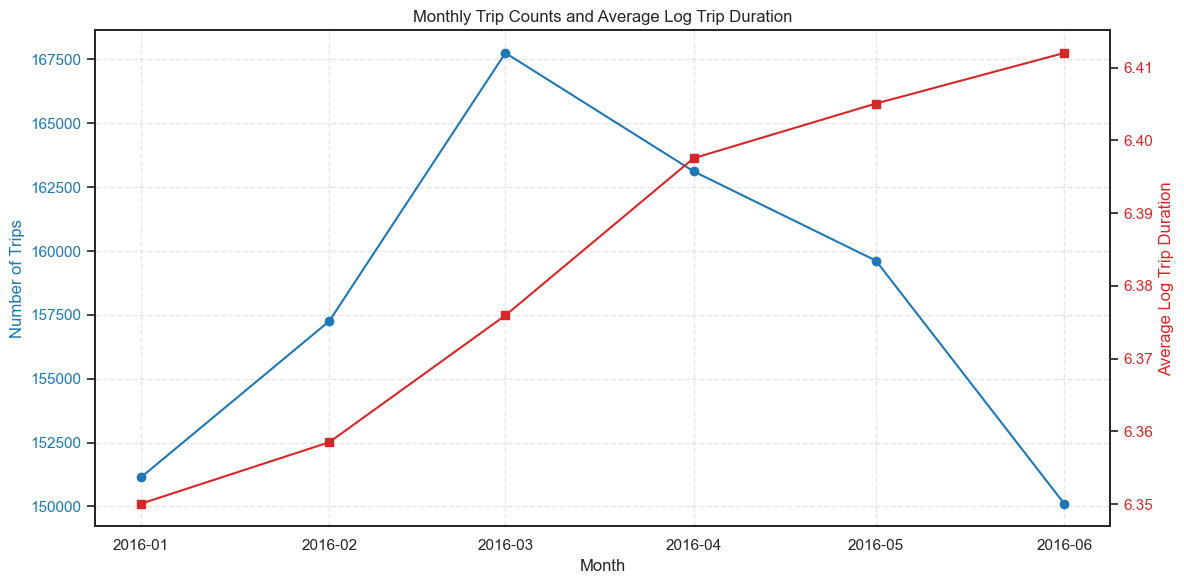

In [417]:
# Prepare data
months = df['pickup_datetime'].dt.to_period('M')
log_durations = df['log_trip_duration']

temp_df = pd.DataFrame({'month': months, 'log_trip_duration': log_durations})

# Calculate monthly stats
monthly_counts = temp_df.groupby('month').size()
avg_log_duration = temp_df.groupby('month')['log_trip_duration'].mean()

# Convert PeriodIndex to timestamps for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()
avg_log_duration.index = avg_log_duration.index.to_timestamp()

# Plot with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Trips', color=color1)
ax1.plot(monthly_counts.index, monthly_counts.values, marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis

color2 = 'tab:red'
ax2.set_ylabel('Average Log Trip Duration', color=color2)
ax2.plot(avg_log_duration.index, avg_log_duration.values, marker='s', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Monthly Trip Counts and Average Log Trip Duration')
fig.tight_layout()
plt.show()

- January shows the lowest number of trips and the highest average log trip duration, largely due to the anomaly we discussed earlier.
- From January through June, there is a general upward trend in average log trip duration, which could be related to warmer weather encouraging more people to travel to various destinations compared to colder months.
- Summer begins in June, making it one of the busiest months in NYC as tourism picks up. This may help explain why January has the highest average trip duration — many tourists arrive via the airport, which is located a bit farther from the city, as shown in the geographical analysis, resulting in longer taxi trips compared to the following months.

[(back to top)](#eda-structure)

### 7. Relationships Between Features

In this section, we’ll explore the relationships between different features to uncover insights that could inform our feature engineering process. Earlier, we examined the connection between geographical features and the `store_and_fwd_flag`, and observed that the flag is more likely to be `"Y"` (indicating the data was stored due to a connection issue) during longer trips—such as those from the airport to downtown. Building on that, we’ll now look for similar meaningful patterns among other features.

#### `pickup_datetime` &  `passenger_count`

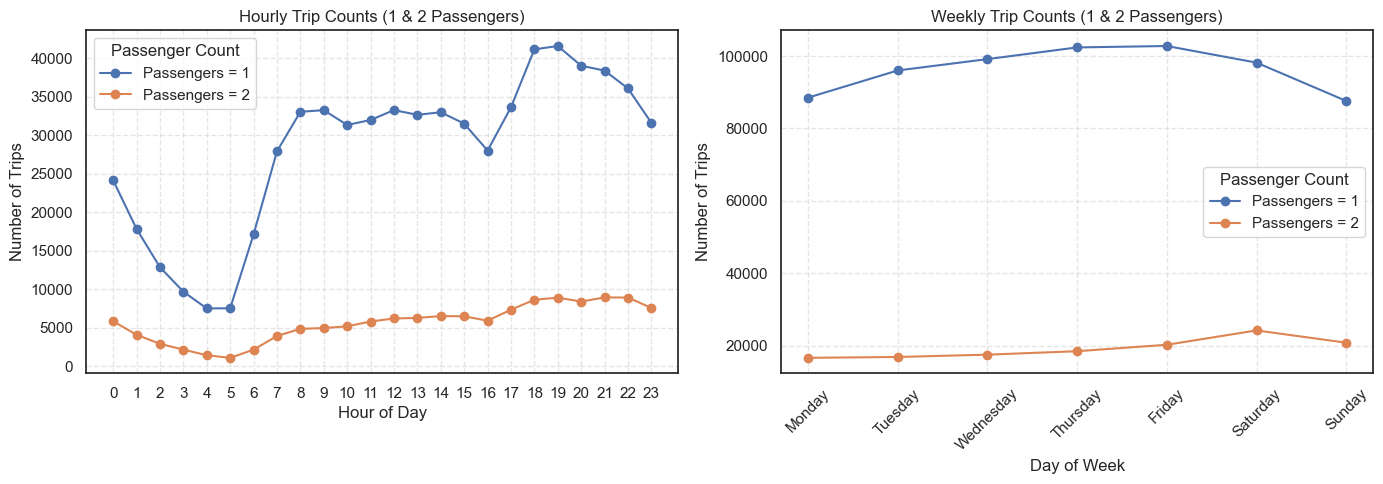

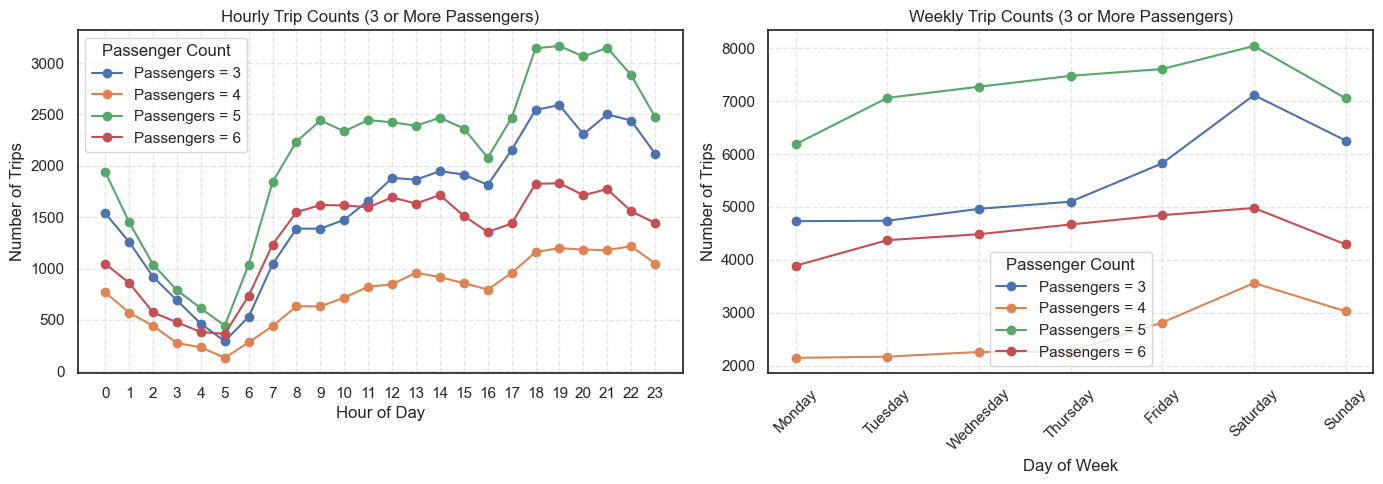

In [418]:
# Prepare data with hour and day_of_week (no permanent change)
df_temp = df.copy()
df_temp['hour'] = df_temp['pickup_datetime'].dt.hour
df_temp['day_of_week'] = df_temp['pickup_datetime'].dt.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

group1 = [1, 2]
group2 = [pc for pc in sorted(df_temp['passenger_count'].unique()) if pc not in group1]

def plot_group(passenger_list, title_suffix):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Hourly plot
    for pc in passenger_list:
        temp_df = df_temp[df_temp['passenger_count'] == pc]
        hourly_counts = temp_df.groupby('hour').size()
        axes[0].plot(hourly_counts.index, hourly_counts.values, marker='o', label=f'Passengers = {pc}')
    axes[0].set_title(f'Hourly Trip Counts {title_suffix}')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_xticks(range(0, 24))
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].legend(title='Passenger Count')

    # Weekly plot
    for pc in passenger_list:
        temp_df = df_temp[df_temp['passenger_count'] == pc]
        weekly_counts = temp_df.groupby('day_of_week').size().reindex(days_order)
        axes[1].plot(weekly_counts.index, weekly_counts.values, marker='o', label=f'Passengers = {pc}')
    axes[1].set_title(f'Weekly Trip Counts {title_suffix}')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Number of Trips')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    axes[1].legend(title='Passenger Count')

    plt.tight_layout()
    plt.show()

# Plot group 1 (1 and 2 passengers)
plot_group(group1, '(1 & 2 Passengers)')

# Plot group 2 (3 and more passengers)
plot_group(group2, '(3 or More Passengers)')

- On Saturday, the first day of the weekend, trips with just 1 passenger tend to decrease compared to other days of the week. Meanwhile, trips with higher passenger counts—especially those with 4 passengers—show a slight increase relative to other weekdays. This pattern likely reflects that on weekends, people spend more time with family and friends, resulting in more group trips rather than solo rides.
- The hourly distributions appear very similar across all passenger counts, suggesting there isn’t a significant relationship between the number of passengers and the time of day.

#### `vendor_id` &  `passenger_count`

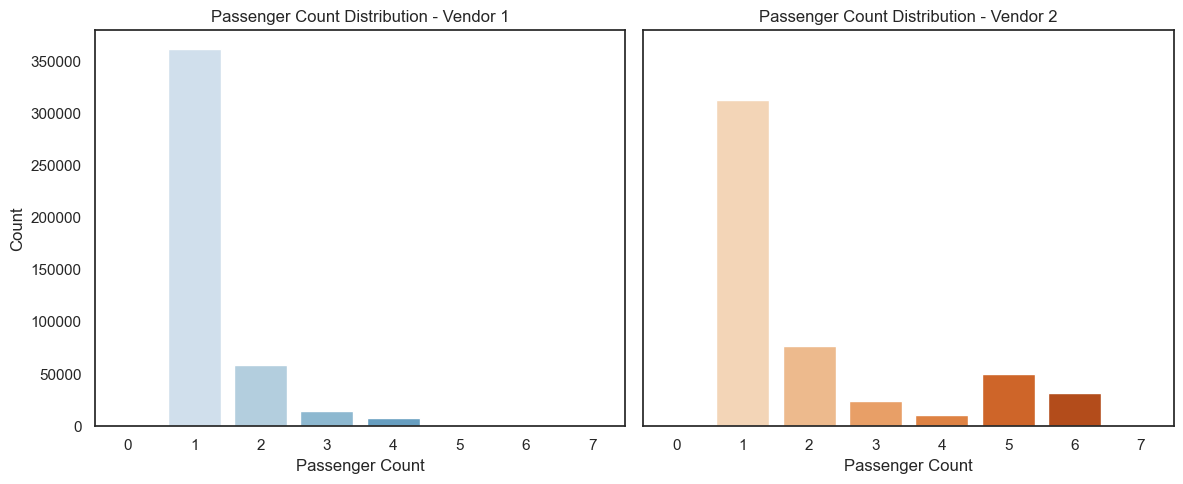

In [419]:
# Filter data for each vendor
df_1 = df[df["vendor_id"] == 1]
df_2 = df[df["vendor_id"] == 2]

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot for Vendor 1
sns.countplot(x='passenger_count', data=df_1, ax=axes[0], palette='Blues')
axes[0].set_title('Passenger Count Distribution - Vendor 1')
axes[0].set_xlabel('Passenger Count')
axes[0].set_ylabel('Count')

# Plot for Vendor 2
sns.countplot(x='passenger_count', data=df_2, ax=axes[1], palette='Oranges')
axes[1].set_title('Passenger Count Distribution - Vendor 2')
axes[1].set_xlabel('Passenger Count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In the following count plots showing the relationship between vendor and passenger count, both vendors display similar overall patterns with three key differences:

1. Vendor 1 has the highest number of trips with just 1 passenger.
2. Vendor 2 records slightly more trips with 2, 3, and 4 passengers compared to Vendor 1.
3. Only Vendor 2 has trips with more than 4 passengers, suggesting that Vendor 2 may operate larger vehicles than Vendor 1.

[(back to top)](#eda-structure)

### 8. Feature Engineering

For feature engineering, we’ll begin by exploring categorical features, followed by geographical features, and finally datetime features. After these individual stages, we’ll move on to a fourth stage that involves creating features by combining variables across different categories to uncover meaningful patterns. This structured, step-by-step approach helps maintain focus and encourages the creation of unique, valuable features. To evaluate which features to retain, we will use correlation or association matrices to measure relationships and ensure low multicollinearity in the final dataset.

#### 8.1 Transforming Categorical Features

In [420]:
df.select_dtypes("category").describe().T

,count,unique,top,freq
vendor_id,948991,2,2,506193
passenger_count,948991,6,1,674623
store_and_fwd_flag,948991,2,N,944104


Since we observed that only **Vendor 2** handles trips with more than 4 passengers, it's likely that this vendor operates larger vehicles. Based on this, we can engineer a new feature called `requires_large_vehicle`, which will be **True** when the `passenger_count` is greater than 4, as smaller groups typically don’t require a large vehicle.

From the [Categorical Feature Analysis](#4-categorical-feature-analysis), we found that both vendors exhibit a similar distribution in `trip_duration`. The key difference seems to lie in their working hours rather than performance. This suggests that the choice of vendor does not significantly impact trip duration, so we may consider dropping the `vendor_id` feature during the modeling phase—especially since the essential information about vehicle size is already captured by the newly created feature.

Finally, regarding the `store_and_fwd_flag`, we noticed during the [Geographical Feature Analysis](#5-geographical-feature-analysis) that trips with the flag set to `"Y"` might correspond to longer durations. Therefore, simply encoding this flag should be sufficient—no additional transformation is necessary.

In [421]:
df['requires_large_vehicle'] = ((df['passenger_count'] == 5) | (df['passenger_count'] == 6)).astype("int")

In [422]:
df.requires_large_vehicle.value_counts()

requires_large_vehicle
0    866761
1     82230
Name: count, dtype: int64

#### 8.2 Transforming Geographical Features

In [423]:
geo_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

For this category, we can engineer two types of **numerical features**:

1. **Meaningful Features**

These are based on domain knowledge and have clear interpretations:

* `trip_distance`: Calculated from coordinates using a distance formula.
* `is_jfk_airport`: Indicates whether the pickup or dropoff location falls within the coordinate range of JFK Airport.
* `is_lg_airport`: Indicates whether the pickup or dropoff location falls within the coordinate range of LaGuardia Airport.

These airport-related features were motivated by the patterns observed in the [Geographical Feature Analysis](#5-geographical-feature-analysis), where we saw a strong association between airport trips and longer trip durations.

2. **Numerical Transformations**

These are derived from mathematical operations to capture potential patterns in the raw coordinate values:

* `coord_arithmetic_mean`: The average of all coordinate values.
* `coord_geometric_mean`: The geometric mean of coordinate values.
* `coord_harmonic_mean`: The harmonic mean of coordinate values.
* `coord_square_sum`: The sum of squares of all coordinates.
* `trip_distance_cube` & `trip_distance_sqrt` & `trip_distance_square`: Calculated from `trip_distance` to represent it in another dimension.

Once these engineered features are added, we may consider removing the original coordinate columns to reduce potential multicollinearity.


In [424]:
# Using distance formula:
# https://www.chegg.com/homework-help/questions-and-answers/point-latitude-373198-point-longitude-121936-point-b-latitude-373185-point-b-longitude-121-q56508606

R = 6356  # radius of Earth in km

# Convert degrees to radians
lat1 = np.radians(df["pickup_latitude"])
lat2 = np.radians(df["dropoff_latitude"])
lon1 = np.radians(df["pickup_longitude"])
lon2 = np.radians(df["dropoff_longitude"])

# x and y components of distance
x = R * (lat1 - lat2)
y = R * (lon1 - lon2) * np.cos(lat2)

# Euclidean distance approximation
df["trip_distance"] = np.sqrt(x**2 + y**2)
df["trip_distance_sqrt"] = np.sqrt(np.sqrt(x**2 + y**2))
df["trip_distance_square"] = x**2 + y**2
df["trip_distance_cube"] = (np.sqrt(x**2 + y**2))**3

In [425]:
# Coordinates are taken from Google Maps
JFK_LATITUDE_RANGE = [40.620998, 40.683139]
JFK_LONGITUDE_RANGE = [-73.841476, -73.729188]

LG_LATITUDE_RANGE = [40.763557, 40.787499]
LG_LONGITUDE_RANGE = [-73.899899, -73.848085]

# JFK bounding box
df["is_jfk_airport"] = (
    ((df["pickup_latitude"].between(JFK_LATITUDE_RANGE[0], JFK_LATITUDE_RANGE[1])) &
     (df["pickup_longitude"].between(JFK_LONGITUDE_RANGE[0], JFK_LONGITUDE_RANGE[1])))
    |
    ((df["dropoff_latitude"].between(JFK_LATITUDE_RANGE[0], JFK_LATITUDE_RANGE[1])) &
     (df["dropoff_longitude"].between(JFK_LONGITUDE_RANGE[0], JFK_LONGITUDE_RANGE[1])))
).astype("int")

# LaGuardia bounding box
df["is_lg_airport"] = (
    ((df["pickup_latitude"].between(LG_LATITUDE_RANGE[0], LG_LATITUDE_RANGE[1])) &
     (df["pickup_longitude"].between(LG_LONGITUDE_RANGE[0], LG_LONGITUDE_RANGE[1])))
    |
    ((df["dropoff_latitude"].between(LG_LATITUDE_RANGE[0], LG_LATITUDE_RANGE[1])) &
     (df["dropoff_longitude"].between(LG_LONGITUDE_RANGE[0], LG_LONGITUDE_RANGE[1])))
).astype("int")

In [426]:
from scipy.stats import gmean, hmean

# Ensure geo_features is a 2D NumPy array (shape: [n_samples, n_features])
geo_array = df[geo_columns].to_numpy()

# axis = 1 ensures row wise operations
df['coord_arithmetic_mean'] = np.mean(geo_array, axis=1)
df['coord_geometric_mean'] = gmean(np.abs(geo_array), axis=1)
df['coord_harmonic_mean'] = hmean(np.abs(geo_array), axis=1)
df['coord_square_sum'] = np.sum(geo_array ** 2, axis=1)

#### 8.3 Transforming Temporal Features

For temporal features, we focus on two main categories:

1. **Decomposing the datetime** into smaller components such as:
   `dayofweek`, `month`, `hour`, `dayofyear`, `weekday`, and `season`.

2. **Deriving meaningful features** from those components, including:
   `is_summer`, `is_rush_hour`, `is_weekend`, and `is_night`.

These features are added based on patterns observed during analysis. For example:

* **Rush hour** can increase trip duration due to traffic congestion.
* **Nighttime** tends to show a decrease in trip duration.
* **Summer** is associated with longer trips, as seen in the [Temporal Feature Analysis](#6-temporal-feature-analysis).
* **Weekend** features were included due to their connection with higher passenger counts per trip.

However, many of these features may be **highly correlated** with each other. We’ll address potential multicollinearity during the modeling phase by evaluating feature importance and selecting only the most impactful ones.

In [427]:
df['dayofyear'] = df.pickup_datetime.dt.dayofyear
df['dayofweek'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

In [428]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall (September, October, November)

df['season'] = df['month'].apply(get_season)

In [429]:
df["is_summer"] = (df["season"] == 2).astype("int")
df["is_rush_hour"] = ((df["hour"].between(7, 9)) | (df["hour"].between(16, 19))).astype("int")
df["is_night"] = ((df["hour"] > 1) & (df["hour"] < 6)).astype("int")
df["is_weekend"] =  ((df["weekday"] // 5) == 1).astype("int")

#### 8.4 Transforming Hybrid Features

1. **Virtual Speed**

Since our goal is to predict **trip duration**, we can refer to the fundamental physics formula:
**time = distance / speed**.

We already computed the **distance** using pickup and dropoff coordinates, so the missing component is an estimate of the **speed**. To create this, we introduce a feature called `virtual_speed`, which serves as a proxy for the actual speed under varying conditions.

In earlier analysis, we identified several factors that tend to **increase trip duration**. We’ll use these factors to progressively reduce a base speed value, forming our `virtual_speed`. The logic is simple: the more factors that slow down the trip, the **slower** the `virtual_speed`.

The main factors considered are:

1. **Airport Proximity** – Trips starting or ending near airports (JFK or LaGuardia) tend to be longer. We'll use the previously created features: `is_jfk_airport` and `is_lg_airport`.
2. **Rush Hour** – Congestion during rush hour likely causes longer durations. We'll use the `is_rush_hour` feature.
3. **Summer Season** – Trips are generally longer in the summer, potentially due to increased tourism. This is captured by the `is_summer` feature.
4. **Store and Forward Flag** – When the `store_and_fwd_flag` is "Y", the trip might have passed through areas with weak signals, indicating potential long or edge-city routes.

To quantify this, we set an initial **base speed** of `2^(4 + 1) = 32`. For each active (i.e., `True`) condition above, we halve the virtual speed. This results in a virtual speed ranging from:

* **32** (if none of the factors are true),
* to **2** (if all four are true).

This approach intuitively aligns with our assumption: **more conditions → slower speed → longer duration**. On the flip side, fewer conditions imply less delay and thus a **faster virtual speed**.

---

2. **Virtual Time**

Once we compute `virtual_speed`, we can calculate a new feature called `virtual_time` using the same time formula:

> **virtual\_time = trip\_distance / virtual\_speed**

This acts as an alternative estimation of the trip duration based on contextual factors.

Additionally, to increase the chances of capturing nonlinear relationships with the actual target (`trip_duration`), we will also include:

* `virtual_speed³`
* `virtual_time³`
* `virtual_time_dist_sqrt` = `trip_distance_sqrt` \ `virtual_speed`

These engineered features may help improve the model’s performance by highlighting hidden patterns.

In [430]:
BASE_SPEED = 32

df['virtual_speed'] = BASE_SPEED / (2 ** (
                        (df['is_jfk_airport'] | df["is_lg_airport"]).astype("int") + # cast bool to int
                        (df['is_rush_hour']).astype("int") +
                        (df['is_summer']).astype("int") + 
                        (df['store_and_fwd_flag'] == 'Y').astype("int")
                        ))

df.virtual_speed.describe().T

count    948991.000000
mean         23.763549
std           8.813346
min           2.000000
25%          16.000000
50%          32.000000
75%          32.000000
max          32.000000
Name: virtual_speed, dtype: float64

In [431]:
df['virtual_time'] = df['trip_distance'] / df['virtual_speed']

In [432]:
# Adding the cubes
df['virtual_speed_cube'] = df['virtual_speed'] ** 3 
df['virtual_time_cube'] = df['virtual_time'] ** 3
df["virtual_time_dist_sqrt"] = df['trip_distance_sqrt'] / df['virtual_speed']

#### 8.5 Assessing Features

In [433]:
print("Categorical Columns: "); print(df.select_dtypes("category").columns); print()
print("Numerical Columns: "); print(df.select_dtypes("number").columns); print()
print("Datetime Columns: "); print(df.select_dtypes("datetime").columns); print()

# Counts
print("Categorical Count: ", end=""); print(df.select_dtypes("category").columns.value_counts().sum())  # categorical
print("Numerical Count: ", end=""); print(df.select_dtypes("number").columns.value_counts().sum())  # numerical
print("Datetime Count: ", end=""); print(df.select_dtypes("datetime").columns.value_counts().sum())  # datetime
print("Total Count: ", end=""); print(df.columns.value_counts().sum())  # total 34,  30 numbers, 3 categories, 1 datetime

Categorical Columns: 
Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag'], dtype='object')

Numerical Columns: 
Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'log_trip_duration', 'requires_large_vehicle',
       'trip_distance', 'trip_distance_sqrt', 'trip_distance_square',
       'trip_distance_cube', 'is_jfk_airport', 'is_lg_airport',
       'coord_arithmetic_mean', 'coord_geometric_mean', 'coord_harmonic_mean',
       'coord_square_sum', 'dayofyear', 'dayofweek', 'month', 'weekday',
       'hour', 'season', 'is_summer', 'is_rush_hour', 'is_night', 'is_weekend',
       'virtual_speed', 'virtual_time', 'virtual_speed_cube',
       'virtual_time_cube', 'virtual_time_dist_sqrt'],
      dtype='object')

Datetime Columns: 
Index(['pickup_datetime'], dtype='object')

Categorical Count: 3
Numerical Count: 31
Datetime Count: 1
Total Count: 35


As shown above, we now have a total of 35 columns. Since including all of them may lead to multicollinearity and hurt model performance, we will categorize the features into four groups based on their meaning and their correlation with the target variable, as evaluated using the correlation matrix:

1. **Directly Selected Features**
   These features have a strong correlation with `trip_duration` and will be directly used in the modeling phase.

2. **Features Requiring Encoding**
   These features contain categorical or special values. They will be kept but transformed using suitable encoding techniques (e.g., one-hot or label encoding), with brief justifications provided for each choice.

3. **Features for Selection Testing**
   These features will undergo evaluation during the modeling phase. Their usefulness will be tested through performance-based comparisons, and only those that contribute positively will be retained in the final model.

4. **Dropped Features**
   These will be removed due to low predictive value, redundancy, or high multicollinearity with other more informative features. Removing them helps simplify the model and reduce noise.


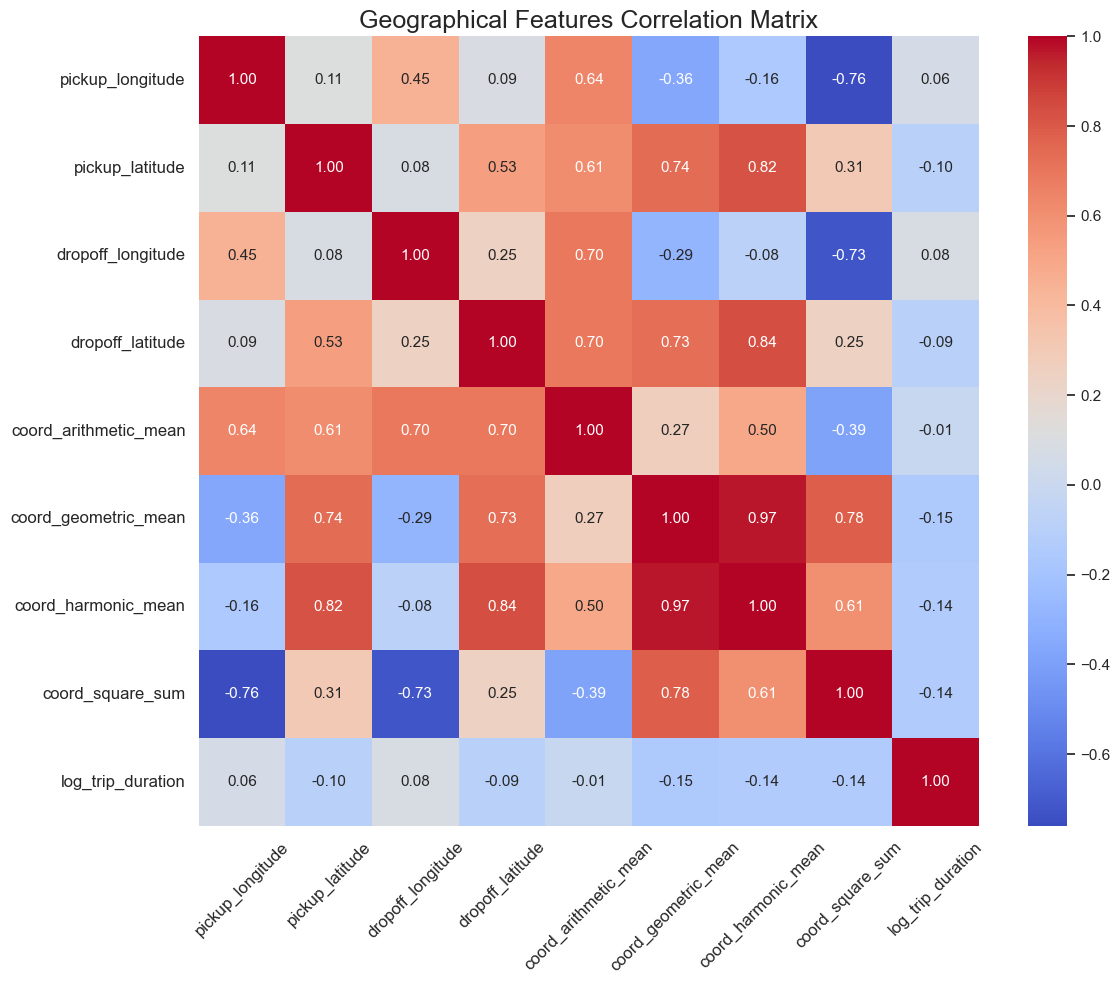

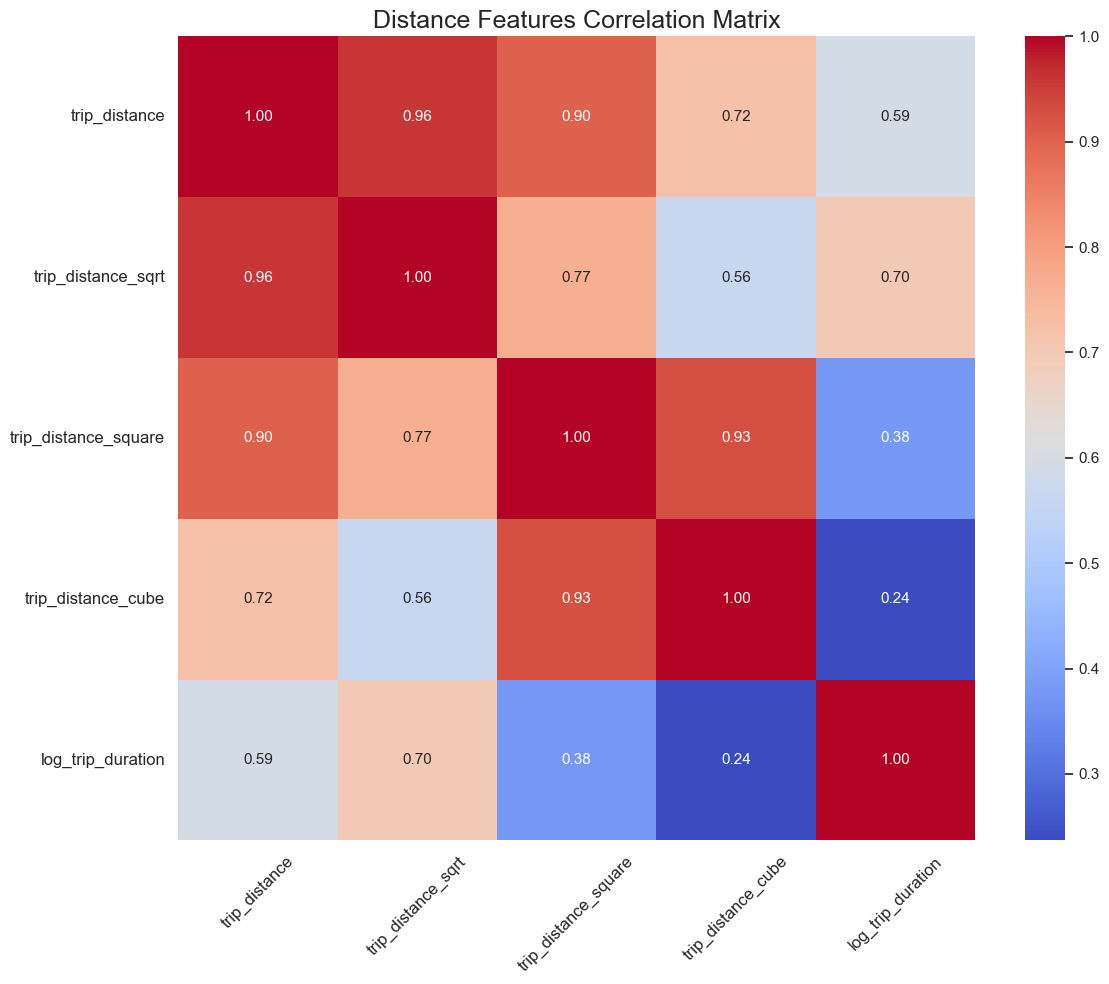

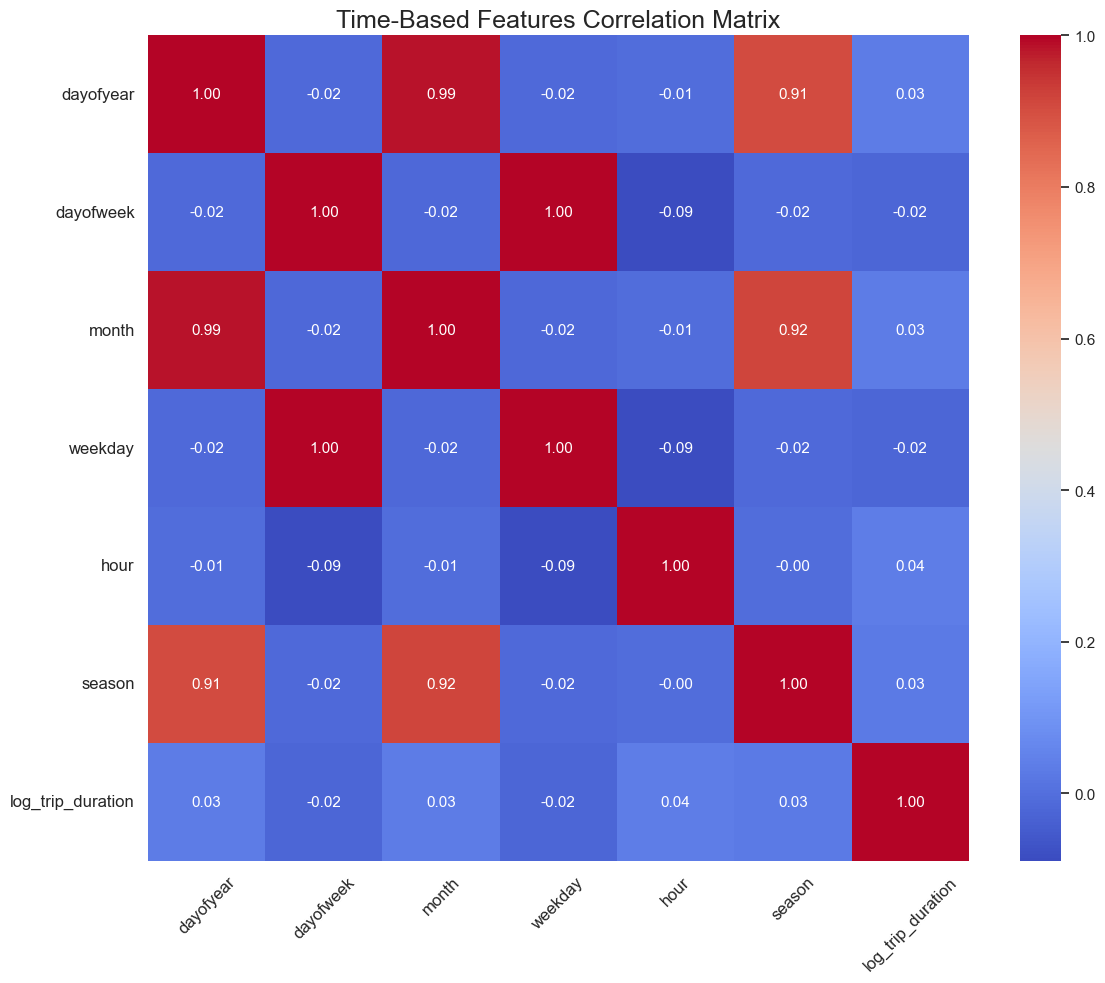

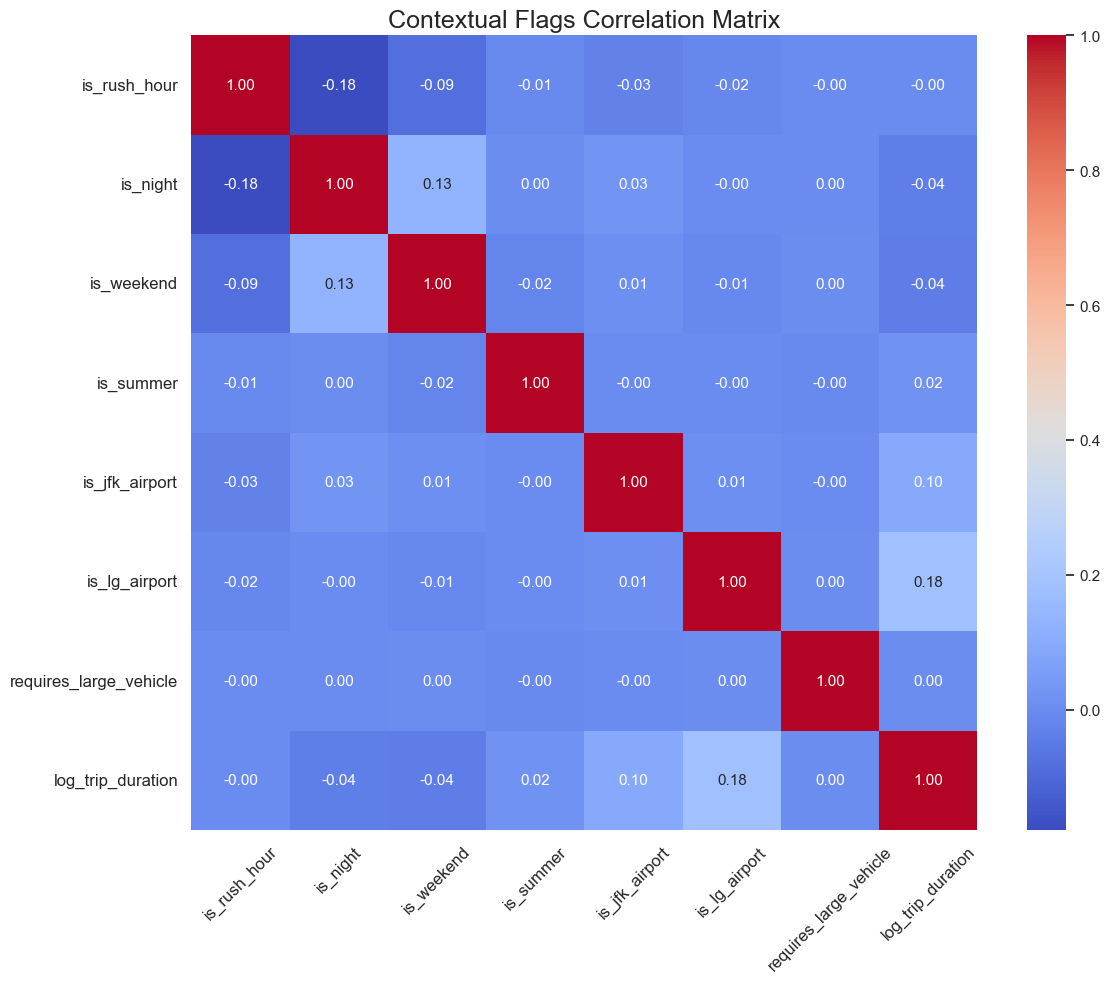

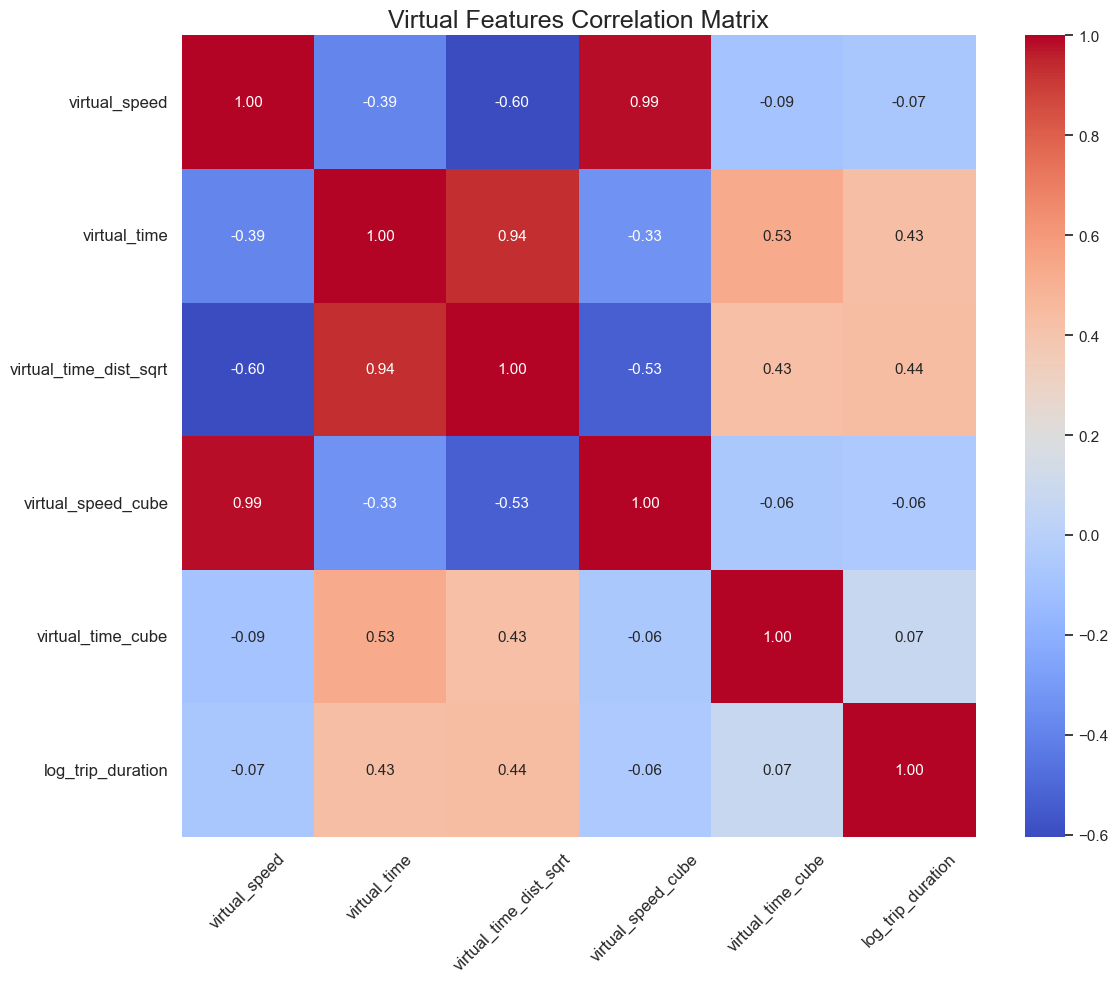

In [434]:
# Splitting features into groups for easier correlation analysis

geo_features = [
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'coord_arithmetic_mean', 'coord_geometric_mean', 'coord_harmonic_mean',
    'coord_square_sum',
    'log_trip_duration'
]

distance_features = [
    'trip_distance', 'trip_distance_sqrt',
    'trip_distance_square', 'trip_distance_cube',
    'log_trip_duration'
]

time_features = [
    'dayofyear', 'dayofweek', 'month', 'weekday', 'hour', 'season',
    'log_trip_duration'
]

contextual_flags = [
    'is_rush_hour', 'is_night', 'is_weekend',
    'is_summer', 'is_jfk_airport', 'is_lg_airport',
    'requires_large_vehicle',
    'log_trip_duration'
]

virtual_features = [
    'virtual_speed', 'virtual_time', 'virtual_time_dist_sqrt',
    'virtual_speed_cube', 'virtual_time_cube',
    'log_trip_duration'
]

# All feature groups and titles
feature_groups = [
    (geo_features, "Geographical Features"),
    (distance_features, "Distance Features"),
    (time_features, "Time-Based Features"),
    (contextual_flags, "Contextual Flags"),
    (virtual_features, "Virtual Features"),
]

# Plotting
for features, title in feature_groups:
    plt.figure(figsize=(12, 10))  # Bigger now
    sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap="coolwarm",
                annot_kws={"size": 11})
    plt.title(f"{title} Correlation Matrix", fontsize=18)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()


**Feature Selection and Explanations**

**Selected Features** (Count = **8**)

These features show relatively high correlation with the target variable and are expected to contribute positively to the model's performance:

* `'coord_harmonic_mean'`
* `'coord_square_sum'`
* `'trip_distance_sqrt'`  *(highest correlation among distance-based features)*
* `'is_jfk_airport'` *(strong correlation with target)*
* `'is_lg_airport'`
* `'virtual_time_dist_sqrt'`
* `'virtual_speed'`
* `'virtual_time_cube'`

**Selected with Encoding** (Count = **3**)

* `'vendor_id'`: *Consider using one-hot encoding to prevent implying an ordinal relationship (e.g., `2 > 1`).*
* `'passenger_count'`: *One-hot encoding is advisable to avoid suggesting a false numerical order.*
* `'store_and_fwd_flag'`: *Target encoding may be useful to reflect the mean impact of this feature on the target variable.*

**To Be Evaluated During Feature Selection Phase** (Count = **14**)

These features either have low individual correlation with the target or are derived from other used variables. They will be tested during the modeling phase to assess their actual contribution to performance:

* `'pickup_longitude'`, `'pickup_latitude'`, `'dropoff_longitude'`, `'dropoff_latitude'`
* `'trip_distance_square'`, `'trip_distance_cube'` *(less promising than sqrt version due to low correlation, but still tested)*
* `'weekday'`, `'hour'`, `'season'` *(low correlation but potentially useful in combinations)*
* `'is_rush_hour'`, `'is_night'`, `'is_weekend'`, `'is_summer'`, `'requires_large_vehicle'` *(part of virtual feature calculations, weak correlation individually)*

**Dropped Features** (Count = **9**)

These features are either:

* redundant due to strong correlation with other selected variables, or
* less meaningful for the model based on their weak individual correlation with the target.

Dropped features:

* `'pickup_datetime'` *(raw date not useful for future predictions; already decomposed into time features)*
* `'coord_arithmetic_mean'` *(very low correlation with target)*
* `'coord_geometric_mean'` *(highly correlated with other coordinate features)*
* `'trip_distance'` *(highly correlated with sqrt version, which performs better)*
* `'dayofyear'`, `'month'`, `'dayofweek'` *(redundant due to correlation with `'season'`)*
* `'virtual_time'` *(strongly correlated with virtual distance and lower correlation with target)*
* `'virtual_speed_cube'` *(adds little beyond `'virtual_speed'`, and highly correlated with it)*


**Final Count:**
8 selected numerical + 3 categorical to encode + 14 to test + 9 dropped = **34 features**

* **1 target** (`log_trip_duration`) → **Total: 35 columns**.

In [435]:
# Dropping Columns

def drop_col(df, col):
    df.drop(col, axis=1, inplace=True)

drop_cols = ['pickup_datetime', 'coord_arithmetic_mean', 'coord_geometric_mean', 'trip_distance',
             'dayofyear', 'month', 'dayofweek', 'virtual_time', 'virtual_speed_cube']

for col in drop_cols:
    drop_col(df, col)

In [436]:
print(df.shape, df.columns, sep="\n")

(948991, 26)
Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'log_trip_duration', 'requires_large_vehicle', 'trip_distance_sqrt',
       'trip_distance_square', 'trip_distance_cube', 'is_jfk_airport',
       'is_lg_airport', 'coord_harmonic_mean', 'coord_square_sum', 'weekday',
       'hour', 'season', 'is_summer', 'is_rush_hour', 'is_night', 'is_weekend',
       'virtual_speed', 'virtual_time_cube', 'virtual_time_dist_sqrt'],
      dtype='object')


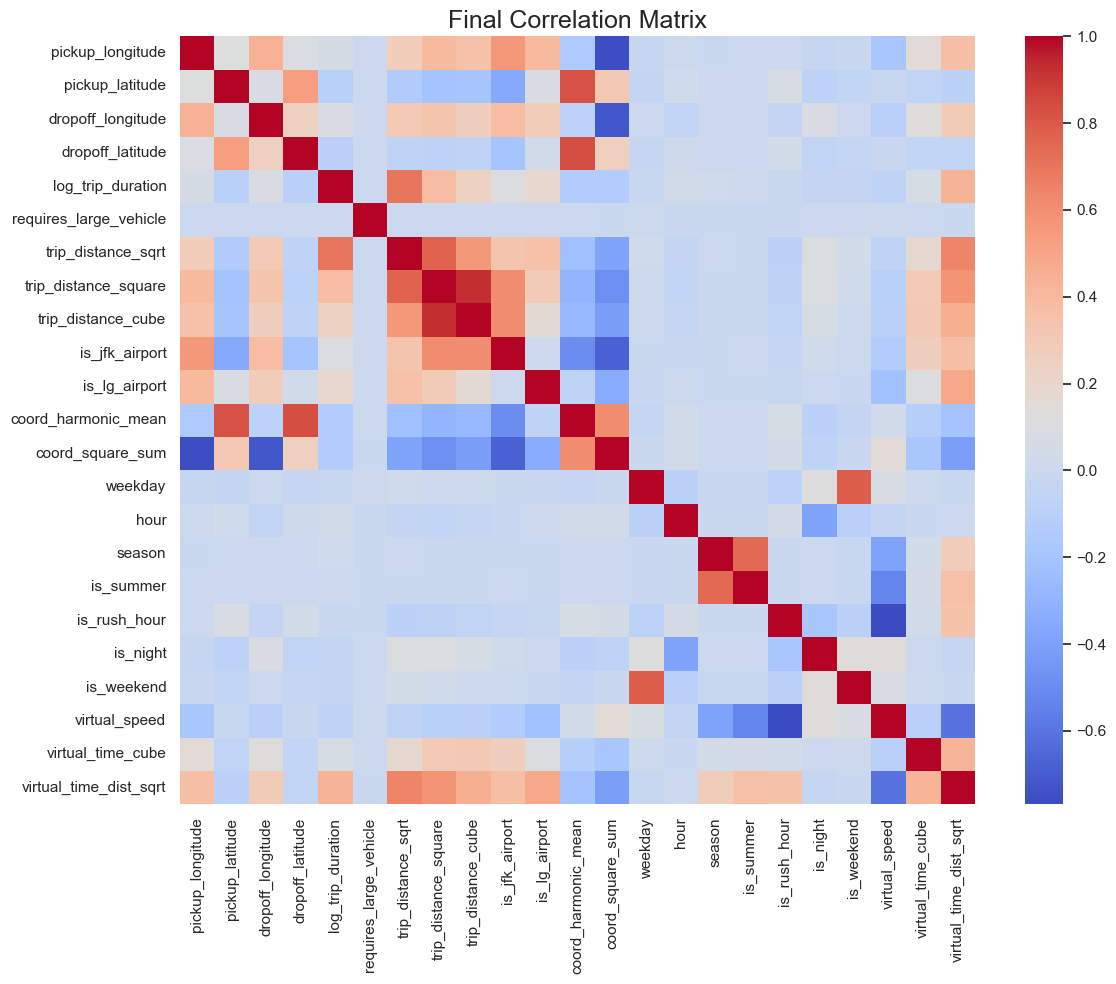

In [437]:
# Final Plot
plt.figure(figsize=(12, 10))  # Bigger now
sns.heatmap(df.select_dtypes("number").corr(), cmap="coolwarm",
            annot_kws={"size": 11})
plt.title(f"Final Correlation Matrix", fontsize=18)
plt.tight_layout()
plt.show()

[(back to top)](#eda-structure)

### 9. Summary and Next Steps

**Summary of the Analysis:**

- Began by cleaning the dataset and examining relationships between features and the target (`trip_duration`).
  - Found that trips starting from airports generally have longer durations.
  - Observed that summer months tend to have longer trip durations.

- Explored feature-to-feature relationships:
  - Identified daily rush hours with significantly higher trip counts.
  - Discussed how such time-based patterns might influence trip duration.

- Performed extensive feature engineering:
  - Created new features within the same category (e.g., `is_summer`).
  - Developed hybrid features by combining existing ones.
    - Example: `virtual_speed`, designed to mimic real-world speed using distance and `is_summer` like flag features.
  - These engineered features showed improved correlation with the target variable.

*Note: These are only some of the many findings and insights extracted during the EDA — there is much more covered throughout the notebook.*

**Next Steps:**

- Conduct feature selection to identify the most impactful engineered features.
- Perform final cleaning based on EDA findings.
- Build and evaluate predictive models using the selected features.
- Account for anomalies (e.g., a blizzard event) during modeling to avoid skewed results.
- Compare multiple models and select the one with the best performance.

[(back to top)](#eda-structure)

### Acknowledgments

- The dataset used in this project is private and not publicly accessible.
- Some code snippets for generating plots were created with the assistance of ChatGPT. However, all plot ideas and insights are my own.

[(back to top)](#eda-structure)